<a href="https://colab.research.google.com/github/BTT-Cadence-Design-Systems-2A/AI-Studio-Project/blob/Bert-base-multilingual-uncased-sentiment/Cadence_2A_Bert_base_cased_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Install libraries**

In [1]:
!pip install -U datasets huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.35.0
    Uninstalling huggingface-hub-0.35.0:
      Successfully uninstalled huggingface-hub-0.35.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine

**Imports & config**

In [2]:
import json
import fsspec
from itertools import islice
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt_tab")

REPO = "McAuley-Lab/Amazon-Reviews-2023"


CATEGORIES = ["Software", "Video_Games", "All_Beauty"]
ALL_CATEGORIES = ["All_Beauty", "Amazon_Fashion", "Appliances", "Arts_Crafts_and_Sewing", "Automotive", "Baby_Products", "Beauty_and_Personal_Care", "Books",
              "CDs_and_Vinyl", "Cell_Phones_and_Accessories", "Clothing_Shoes_and_Jewelry", "Digital_Music", "Electronics", "Gift_Cards", "Grocery_and_Gourmet_Food",
              "Handmade_Products", "Health_and_Household", "Health_and_Personal_Care", "Home_and_Kitchen", "Industrial_and_Scientific",
              "Kindle_Store", "Magazine_Subscriptions", "Movies_and_TV", "Musical_Instruments", "Office_Products", "Patio_Lawn_and_Garden", "Pet_Supplies",
              "Software", "Sports_and_Outdoors", "Subscription_Boxes", "Tools_and_Home_Improvement", "Toys_and_Games", "Video_Games",
              "Unknown"]


N_PER_CAT = 10_000
N_META    = 60_000

pd.set_option("display.max_colwidth", 200)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


**Load & sample each category (streaming) and concatenate**

In [3]:
def stream_jsonl(url: str, limit: int | None = None):
    """
    Stream a JSONL file line-by-line from Hugging Face
    Normalizes mixed-type fields like 'price'
    """
    with fsspec.open(url, "rt") as f:
        for idx, line in enumerate(f):
            if limit is not None and idx >= limit:
                break
            obj = json.loads(line)


            if "price" in obj and obj["price"] is not None:
                obj["price"] = str(obj["price"])

            return_obj = obj
            yield return_obj


def ensure_asin(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure there is an 'asin' column
    """
    for cand in ["asin", "parent_asin", "product_id", "item_id", "Parent_ASIN", "ParentAsin"]:
        if cand in df.columns:
            if "asin" not in df.columns:
                df["asin"] = df[cand]
            return df
    if len(df) > 0:
        print("No recognizable ASIN-like key found. Example row:\n", df.head(1).to_dict("records")[0])
    return df


def load_category(category: str, n_reviews: int, n_meta: int):
    """
    Load one category's reviews and meta as DataFrames
    """
    reviews_url = f"hf://datasets/{REPO}/raw/review_categories/{category}.jsonl"
    meta_url    = f"hf://datasets/{REPO}/raw/meta_categories/meta_{category}.jsonl"

    reviews_df = pd.DataFrame(islice(stream_jsonl(reviews_url), n_reviews)).assign(category=category)
    meta_df    = pd.DataFrame(islice(stream_jsonl(meta_url),    n_meta)).assign(category=category)
    return reviews_df, meta_df

**Inspect schemas and key columns**

In [4]:
all_reviews, all_meta = [], []

for cat in CATEGORIES:
    r_df, m_df = load_category(cat, n_reviews=N_PER_CAT, n_meta=N_META)
    all_reviews.append(r_df)
    all_meta.append(m_df)

reviews_df = pd.concat(all_reviews, ignore_index=True)
meta_df    = pd.concat(all_meta,    ignore_index=True)

reviews_df = ensure_asin(reviews_df)
meta_df    = ensure_asin(meta_df)


if "asin" in reviews_df:
    reviews_df = reviews_df[reviews_df["asin"].notna()]
if "asin" in meta_df:
    meta_df = meta_df[meta_df["asin"].notna()]

print(f"Loaded rows -> reviews: {len(reviews_df):,} | meta: {len(meta_df):,}")
display(reviews_df.head(2))
display(meta_df.head(2))

print(f"Unique products in reviews: {reviews_df['asin'].nunique():,}")
print(f"Unique products in meta: {meta_df['asin'].nunique():,}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded rows -> reviews: 30,000 | meta: 180,000


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,category
0,1.0,malware,mcaffee IS malware,[],B07BFS3G7P,B0BQSK9QCF,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1562182632076,0,False,Software
1,5.0,Lots of Fun,"I love playing tapped out because it is fun to watch the town grow by earning money and buying buildings. I love helping my neighbors, too.",[],B00CTQ6SIG,B00CTQ6SIG,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1424120336000,0,True,Software


,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,category,subtitle,author,asin
0,Appstore for Android,Accupressure Guide,3.6,NaN,[All the pressing point has been explained with the help of image for the ease of the user.],[Acupressure technique is very ancient and very effective technique to cure many medical problems. Acupressure is an ancient healing art that uses the fingers to press key points on the surface of...,0.0,"[{'large': 'https://m.media-amazon.com/images/I/41+4JZcQQyL.jpg', 'variant': 'MAIN'}, {'large': 'https://m.media-amazon.com/images/I/51P-UDgfJUL.jpg', 'variant': 'PT01'}, {'large': 'https://m.medi...","[{'title': '', 'url': '', 'user_id': ''}]",mAppsguru,[],"{'Release Date': '2015', 'Date first listed on Amazon': 'April 8, 2015', 'Developed By': 'mAppsguru', 'Size': '2.3MB', 'Version': '1.0', 'Application Permissions': ['Access information about netwo...",B00VRPSGEO,None,Software,NaN,NaN,B00VRPSGEO
1,Appstore for Android,Ankylosaurus Fights Back - Smithsonian's Prehistoric Pals,4.0,NaN,"[ENCOURAGE literacy skills with highlighted narration, FOLLOW along with three fun ways to read!, LEARN new vocabulary with tappable words, TAP objects to hear their name read aloud]","[Join Ankylosaurus in this interactive book app as he is so busy eating that he doesn’t notice the huge T-rex that is watching him! Explore pictures, learn new vocabulary, and follow along with th...",2.99,"[{'large': 'https://m.media-amazon.com/images/I/A1XJ+0NwHpL.png', 'variant': 'MAIN'}, {'large': 'https://m.media-amazon.com/images/I/A1ALOQjUkVL.png', 'variant': 'PT01'}, {'large': 'https://m.medi...","[{'title': '', 'url': '', 'user_id': ''}]","Oceanhouse Media, Inc",[],"{'Release Date': '2014', 'Date first listed on Amazon': 'September 26, 2014', 'Developed By': 'Oceanhouse Media, Inc', 'Size': '41.6MB', 'Version': '2.30', 'Application Permissions': ['Open networ...",B00NWQXXHQ,None,Software,NaN,NaN,B00NWQXXHQ


Unique products in reviews: 18,846
Unique products in meta: 180,000


**Helper: ensure_asin + normalize IDs**

In [5]:
meta_keys = {"asin", "parent_asin", "category"}
meta_keep = ["asin", "parent_asin"] + [c for c in meta_df.columns if c not in meta_keys]


m1 = reviews_df.merge(meta_df[meta_keep], on="asin", how="left", suffixes=("_review", "_meta"))


m2 = reviews_df.merge(
    meta_df[meta_keep].rename(columns={"asin": "asin_meta2", "parent_asin": "parent_asin_meta2"}),
    left_on="parent_asin",
    right_on="asin_meta2",
    how="left",
)


merged = m1.copy()
for col in meta_keep:
    if col in {"asin", "parent_asin"}:
        continue
    col_m1 = col
    col_m2 = col + "_m2"
    if col in m2.columns:
        merged[col_m2] = m2[col]
        merged[col] = merged[col].where(merged[col].notna(), merged[col_m2])
        merged.drop(columns=[col_m2], inplace=True)


if "asin_meta2" in m2.columns:
    merged["asin_meta_fallback"] = m2["asin_meta2"]

print("Merged shape:", merged.shape)


meta_signal = [c for c in merged.columns if c.endswith("_meta") or c in ["average_rating", "rating_number", "price", "store", "categories", "details", "title", "images", "videos", "main_category"]]
coverage = merged[meta_signal].notna().any(axis=1).mean() if meta_signal else 0.0
print(f"Rows with ANY meta fields: {coverage:.2%}")

display(merged.head(5))

Merged shape: (30000, 28)
Rows with ANY meta fields: 65.98%


,rating,title_review,text,images_review,asin,parent_asin_review,user_id,timestamp,helpful_vote,verified_purchase,...,price,images_meta,videos,store,categories,details,bought_together,subtitle,author,asin_meta_fallback
0,1.0,malware,mcaffee IS malware,[],B07BFS3G7P,B0BQSK9QCF,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1562182632076,0,False,...,34.99,NaN,"[{'title': 'McAfee REAL Support', 'url': 'https://www.amazon.com/vdp/1d78f93b842f4ad2b7a5784562785995?ref=dp_vse_rvc_0', 'user_id': 'AHL62TTXAOHG7TW7I42NKJJYMWXQ'}, {'title': 'How to Activate and ...",McAfee,"[Software, Antivirus & Security, Internet Security Suites]","{'Product Dimensions': '7.5 x 5.5 x 0.5 inches; 0.49 Ounces', 'Item model number': 'MTP00EAMXRAAS', 'Date First Available': 'September 26, 2018', 'Manufacturer': 'McAfee', 'Country of Origin': 'USA'}",None,NaN,NaN,B0BQSK9QCF
1,5.0,Lots of Fun,"I love playing tapped out because it is fun to watch the town grow by earning money and buying buildings. I love helping my neighbors, too.",[],B00CTQ6SIG,B00CTQ6SIG,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1424120336000,0,True,...,0.0,"[{'large': 'https://m.media-amazon.com/images/I/A1oXfoxcSJL.png', 'variant': 'MAIN'}, {'large': 'https://m.media-amazon.com/images/I/A1REwvZmyCL.png', 'variant': 'PT01'}, {'large': 'https://m.medi...","[{'title': '', 'url': '', 'user_id': ''}]",Electronic Arts,[],"{'Release Date': '2013', 'Date first listed on Amazon': 'June 24, 2013', 'Developed By': 'Electronic Arts', 'Size': '73.2MB', 'Version': '4.62.0', 'Application Permissions': ['ACCESS_DOWNLOAD_MANA...",None,NaN,NaN,B00CTQ6SIG
2,5.0,Light Up The Dark,"I love this flashlight app! It really illuminates the dark, very cool! Get this app, you will love it, really!",[],B0066WJLU6,B0066WJLU6,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1362399267000,0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,Fun game,One of my favorite games,[],B00KCYMAWK,B00KCYMAWK,AH6CATODIVPVUOJEWHRSRCSKAOHA,1561061428662,0,True,...,0.0,"[{'large': 'https://m.media-amazon.com/images/I/A1ZIEO4ZTEL.jpg', 'variant': 'MAIN'}, {'large': 'https://m.media-amazon.com/images/I/B1uBRtRYlVL.png', 'variant': 'PT01'}, {'large': 'https://m.medi...","[{'title': '', 'url': 'https://images-na.ssl-images-amazon.com/images/I/D1uRaN4cXyS.mp4', 'user_id': ''}]",SG Interactive,[],"{'Release Date': '2014', 'Date first listed on Amazon': 'May 22, 2014', 'Developed By': 'SG Interactive', 'Size': '93.3MB', 'Version': '39.0.0', 'Application Permissions': ['Access information abo...",None,NaN,NaN,B00KCYMAWK
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kids are. We love Nik Wallenda!,[],B00P1RK566,B00P1RK566,AEINY4XOINMMJCK5GZ3M6MMHBN6A,1418257196000,0,True,...,0.99,"[{'large': 'https://m.media-amazon.com/images/I/51kWAmsxozL.png', 'variant': 'MAIN'}, {'large': 'https://m.media-amazon.com/images/I/51KW52oWAUL.png', 'variant': 'PT01'}, {'large': 'https://m.medi...","[{'title': '', 'url': '', 'user_id': ''}]",Tapinator,[],"{'Release Date': '2014', 'Date first listed on Amazon': 'November 2, 2014', 'Developed By': 'Tapinator', 'Size': '26.4MB', 'Version': '1.0', 'Application Permissions': ['Access information about n...",None,NaN,NaN,B00P1RK566


# **Milestone #1: Sentiment Analysis of a Singular Review**


Goal: Take the reviews dataframe, only maintain the rating, title, category, and text columns, and then train a model that predicts the rating given a review text


In [6]:
def load_category_into_review(category: str, n_reviews: int):
    """
    Load one category's reviews as DataFrames
    """
    reviews_url = f"hf://datasets/{REPO}/raw/review_categories/{category}.jsonl"

    data = (
        {k: row.get(k) for k in ["rating", "title", "text"]}
        for row in islice(stream_jsonl(reviews_url), n_reviews)
    )

    reviews_df = pd.DataFrame(data).assign(category=category)
    return reviews_df

In [7]:

sentiment_reviews =  []

for cat in ALL_CATEGORIES:
    r_df = load_category_into_review(cat, n_reviews=N_PER_CAT)
    sentiment_reviews.append(r_df)

reviews_df_milestone1 = pd.concat(sentiment_reviews, ignore_index=True)


print(f"Loaded rows -> reviews: {len(reviews_df_milestone1):,}")
display(reviews_df_milestone1.head(2))

Loaded rows -> reviews: 340,000


,rating,title,text,category
0,5.0,Such a lovely scent but not overpowering.,"This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, med...",All_Beauty
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (granted, I did know the smell was descri...",All_Beauty


In [8]:
reviews_df_milestone1.info()
reviews_df_milestone1['rating'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340000 entries, 0 to 339999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   rating    340000 non-null  float64
 1   title     340000 non-null  object 
 2   text      340000 non-null  object 
 3   category  340000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 10.4+ MB


,count
rating,
5.0,224659
4.0,53930
3.0,26023
1.0,21621
2.0,13767


## Milestone #1: Data Cleaning

In [9]:
reviews_df_milestone1.isna().sum()

,0
rating,0
title,0
text,0
category,0


### Text Normalization (removing punctuation)

In [10]:
import string


def remove_punctuation(text: str) -> str:
    """
    Function removes all punctuation from a string
    """
    if not isinstance(text, str):
        return ""
    return text.translate(str.maketrans("", "", string.punctuation))

In [11]:
"""
   Creates clean_review and clean_title and clean_review. These two columns will be used during model training.
"""
reviews_df_milestone1['clean_review'] = (
    reviews_df_milestone1['text']
    .str.lower()
    .apply(remove_punctuation)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

reviews_df_milestone1['clean_title'] = (
    reviews_df_milestone1['title']
    .str.lower()
    .apply(remove_punctuation)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

### Lemmitization of Reviews

In [12]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmas)

In [13]:
reviews_df_milestone1['lemmatized_review'] = reviews_df_milestone1['clean_review'].apply(lemmatize_text)
reviews_df_milestone1['lemmatized_title'] = reviews_df_milestone1['clean_title'].apply(lemmatize_text)

### Creating Sentiment Labels


In [14]:
def create_sentiment_label(rating: int) -> str:
  if rating >= 4:
    return 'positive'
  elif rating <= 2:
    return 'negative'
  else:
    return 'neutral'

In [15]:
reviews_df_milestone1['sentiment_labels'] = (
    reviews_df_milestone1['rating']
    .apply(create_sentiment_label)
)

In [16]:
reviews_df_milestone1.head()

,rating,title,text,category,clean_review,clean_title,lemmatized_review,lemmatized_title,sentiment_labels
0,5.0,Such a lovely scent but not overpowering.,"This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, med...",All_Beauty,this spray is really nice it smells really good goes on really fine and does the trick i will say it feels like you need a lot of it though to get the texture i want i have a lot of hair medium th...,such a lovely scent but not overpowering,this spray is really nice it smell really good go on really fine and doe the trick i will say it feel like you need a lot of it though to get the texture i want i have a lot of hair medium thickne...,such a lovely scent but not overpowering,positive
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (granted, I did know the smell was descri...",All_Beauty,this product does what i need it to do i just wish it was odorless or had a soft coconut smell having my head smell like an orange coffee is offputting granted i did know the smell was described b...,works great but smells a little weird,this product doe what i need it to do i just wish it wa odorless or had a soft coconut smell having my head smell like an orange coffee is offputting granted i did know the smell wa described but ...,work great but smell a little weird,positive
2,5.0,Yes!,"Smells good, feels great!",All_Beauty,smells good feels great,yes,smell good feel great,yes,positive
3,1.0,Synthetic feeling,Felt synthetic,All_Beauty,felt synthetic,synthetic feeling,felt synthetic,synthetic feeling,negative
4,5.0,A+,Love it,All_Beauty,love it,a,love it,a,positive


### Tokenization of Reviews


In [ ]:
# documents = reviews_df_milestone1['clean_review'].tolist()

In [ ]:
# vectorizer = TfidfVectorizer(
#     stop_words="english",   # remove english stopwords like this, a, the, etc
#     # max_features=5000,      # keep top 5000 words (tune this)
# )
# X = vectorizer.fit_transform(documents)

In [ ]:
# print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

# df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
# df_tfidf.head()

In [ ]:
from nltk.tokenize import word_tokenize
reviews_df_milestone1['tokenized_review'] = reviews_df_milestone1['clean_review'].apply(word_tokenize)

In [ ]:
reviews_df_milestone1.head(5)

### Creating another column for sentiment label classes
For this label, we will set 0 - negative, 1 - neutral, 2 - positive.We need this to calculate loss between model output and the ground truth sentiment labels.

In [17]:
def create_sentiment_label_classes(rating: int) -> str:
  if rating >= 4:
    return 2
  elif rating <= 2:
    return 0
  else:
    return 1

In [18]:
reviews_df_milestone1['sentiment_label_classes'] = (
    reviews_df_milestone1['rating']
    .apply(create_sentiment_label_classes)
)

In [19]:
reviews_df_milestone1.head(10)

,rating,title,text,category,clean_review,clean_title,lemmatized_review,lemmatized_title,sentiment_labels,sentiment_label_classes
0,5.0,Such a lovely scent but not overpowering.,"This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, med...",All_Beauty,this spray is really nice it smells really good goes on really fine and does the trick i will say it feels like you need a lot of it though to get the texture i want i have a lot of hair medium th...,such a lovely scent but not overpowering,this spray is really nice it smell really good go on really fine and doe the trick i will say it feel like you need a lot of it though to get the texture i want i have a lot of hair medium thickne...,such a lovely scent but not overpowering,positive,2
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (granted, I did know the smell was descri...",All_Beauty,this product does what i need it to do i just wish it was odorless or had a soft coconut smell having my head smell like an orange coffee is offputting granted i did know the smell was described b...,works great but smells a little weird,this product doe what i need it to do i just wish it wa odorless or had a soft coconut smell having my head smell like an orange coffee is offputting granted i did know the smell wa described but ...,work great but smell a little weird,positive,2
2,5.0,Yes!,"Smells good, feels great!",All_Beauty,smells good feels great,yes,smell good feel great,yes,positive,2
3,1.0,Synthetic feeling,Felt synthetic,All_Beauty,felt synthetic,synthetic feeling,felt synthetic,synthetic feeling,negative,0
4,5.0,A+,Love it,All_Beauty,love it,a,love it,a,positive,2
5,4.0,Pretty Color,The polish was quiet thick and did not apply smoothly. I let dry overnight before adding a second coat since it was so thick.,All_Beauty,the polish was quiet thick and did not apply smoothly i let dry overnight before adding a second coat since it was so thick,pretty color,the polish wa quiet thick and did not apply smoothly i let dry overnight before adding a second coat since it wa so thick,pretty color,positive,2
6,5.0,Handy,"Great for many tasks. I purchased these for makeup removal. No makeup on your washcloths. Disposable, so great for travel. Soft. Absorbant.",All_Beauty,great for many tasks i purchased these for makeup removal no makeup on your washcloths disposable so great for travel soft absorbant,handy,great for many task i purchased these for makeup removal no makeup on your washcloth disposable so great for travel soft absorbant,handy,positive,2
7,3.0,Meh,These were lightweight and soft but much too small for my liking. I would have preferred two of these together to make one loc. For that reason I will not be repurchasing.,All_Beauty,these were lightweight and soft but much too small for my liking i would have preferred two of these together to make one loc for that reason i will not be repurchasing,meh,these were lightweight and soft but much too small for my liking i would have preferred two of these together to make one loc for that reason i will not be repurchasing,meh,neutral,1
8,5.0,Great for at home use and so easy to use!,This is perfect for my between salon visits. I have been using this now twice a week for over a month and I absolutely love it! My skin looks amazing and feels super smooth and silky. This is also...,All_Beauty,this is perfect for my between salon visits i have been using this now twice a week for over a month and i absolutely love it my skin looks amazing and feels super smooth and silky this is also su...,great for at home use and so easy to use,this is perfect for my between salon visit i have been using this now twice a week for over a month and i absolutely love it my skin 

# Bert-base Cased Model for sentiment analysis

### Install libraries

In [20]:
!pip install transformers
!pip install torch
!pip install datasets

### Convert "clean review" column to Dataset

In [21]:
from datasets import Dataset
clean_reviews_dataset = Dataset.from_pandas(reviews_df_milestone1[['clean_review', 'sentiment_label_classes']]).rename_column("sentiment_label_classes", "labels")

In [22]:
print(clean_reviews_dataset)

Dataset({
    features: ['clean_review', 'labels'],
    num_rows: 340000
})


### Load model and model's tokenizer to convert cleaned review text to number embeddings

In [23]:
# Load model directly
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# define the tokenization function
def tokenize_text(examples):
  return tokenizer(examples['clean_review'], padding=True, truncation=True, max_length=128)

# apply tokenization func to the clean review text
tokenized_clean_reviews = clean_reviews_dataset.map(tokenize_text, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/340000 [00:00<?, ? examples/s]

In [24]:
print(tokenized_clean_reviews)

Dataset({
    features: ['clean_review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 340000
})


### Split the tokenized text into training, validation, and test set
We will use 70% training set, 15% validation set and 15% test set

In [25]:
train_dataset, valid_test_dataset = tokenized_clean_reviews.train_test_split(test_size=0.3, seed=42).values()
valid_dataset, test_dataset = valid_test_dataset.train_test_split(test_size=0.5, seed=42).values()

In [26]:
print(train_dataset)
print(f"train dataset shape: {train_dataset.shape}")
print(valid_dataset)
print(f"valid dataset shape: {valid_dataset.shape}")
print(test_dataset)
print(f"test dataset shape: {test_dataset.shape}")

Dataset({
    features: ['clean_review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 238000
})
train dataset shape: (238000, 5)
Dataset({
    features: ['clean_review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 51000
})
valid dataset shape: (51000, 5)
Dataset({
    features: ['clean_review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 51000
})
test dataset shape: (51000, 5)


### Create data loader to manage batches of data during training
Dataloader is used to organize data for model training by providing efficient ways to batch, shuffle, and transform data.


In [27]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

### Setting up the model and config for fine-tuning the model

AdamW is for adjusting learning rate during training.




In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from torch.optim import AdamW

# load the pre-trained bert model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
# define training argument
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Bert-base Multilingual Uncase Model checkpoint', # ouput directory for model checkpoint
    eval_strategy='epoch', # evaluation strategy
    num_train_epochs=3, # num of training epochs
    learning_rate=2e-5, # learning rate
    per_device_train_batch_size=8, # batch size for training
    per_device_eval_batch_size=8, # batch size for evaluation
    weight_decay=0.01 # weight decay

)

NameError: name 'TrainingArguments' is not defined

In [96]:
# define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset
)

In [97]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.463400,0.439781
2,0.382400,0.405350
3,0.366100,0.421329


TrainOutput(global_step=89250, training_loss=0.4188374367935651, metrics={'train_runtime': 5290.5135, 'train_samples_per_second': 134.959, 'train_steps_per_second': 16.87, 'total_flos': 4.6965745064448e+16, 'train_loss': 0.4188374367935651, 'epoch': 3.0})

### Evaluating the model

In [ ]:
!pip install evaluate

In [106]:
res = trainer.predict(test_dataset)
logits = res.predictions # pred scores for each class
labels = res.label_ids # label for each class
pred = logits.argmax(axis=-1)   # pick the class with highest score

In [109]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

acc = accuracy_score(labels, pred)
prec, rec, f1, _ = precision_recall_fscore_support(labels, pred, average="weighted")

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 score:", f1)


Accuracy: 0.8730392156862745
Precision: 0.8523497528612406
Recall: 0.8730392156862745
F1: 0.8604433576104994


### Inference of the fine-tuned model

In [46]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer

'''
SAVING THE TOKENIZER IN THE SAVED CHECKPOINT
finetuned_model_path = "/content/drive/MyDrive/Bert-base Multilingual Uncase Model checkpoint/checkpoint-89250"

## Weight and parameters of the pre-trained model's tokenizer never changed
# reload original pretrained tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")

# save tokenizer into your finetuned model folder
tokenizer.save_pretrained(finetuned_model_path)
'''

'\nSAVING THE TOKENIZER IN THE SAVED CHECKPOINT\nfinetuned_model_path = "/content/drive/MyDrive/Bert-base Multilingual Uncase Model checkpoint/checkpoint-89250"\n\n## Weight and parameters of the pre-trained model\'s tokenizer never changed\n# reload original pretrained tokenizer\ntokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")\n\n# save tokenizer into your finetuned model folder\ntokenizer.save_pretrained(finetuned_model_path)\n'

In [47]:
finetuned_model_path = "/content/drive/MyDrive/Bert-base Multilingual Uncase Model checkpoint/checkpoint-89250"

# load the finetuned model
model = BertForSequenceClassification.from_pretrained(finetuned_model_path)
# load the tokenizer in the finetuned model
tokenizer = BertTokenizer.from_pretrained(finetuned_model_path)

trainer = Trainer(model=model)

# Running prediction
res = trainer.predict(test_dataset)
logits = res.predictions # pred scores for each class
labels = res.label_ids # label for each class
pred = logits.argmax(axis=-1)

In [48]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# print(pred)
acc = accuracy_score(labels, pred)
prec, rec, f1, _ = precision_recall_fscore_support(labels, pred, average="weighted")

print("Accuracy: ", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 score:", f1)

Accuracy:  0.8730392156862745
Precision: 0.8523497528612406
Recall: 0.8730392156862745
F1 score: 0.8604433576104994


### Comparison of Original Bert vs. Finetuned Bert model


In [31]:
# running the original bert-base cased model on the test dataset
from transformers import BertForSequenceClassification, Trainer
num_labels = 3  # adjust to your dataset

orig_model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=num_labels
)
orig_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

orig_trainer = Trainer(model=orig_model)
res = orig_trainer.predict(test_dataset)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kyileiaye2019 (kyileiaye2019-uci) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [34]:
logits = res.predictions # pred scores for each class
labels = res.label_ids # label for each class
orig_model_pred = logits.argmax(axis=-1)

In [39]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# print(pred)
orig_acc = accuracy_score(labels, orig_model_pred)
orig_prec, orig_rec, orig_f1, _ = precision_recall_fscore_support(labels, orig_model_pred, average="weighted")

print("Accuracy: ", orig_acc)
print("Precision:", orig_prec)
print("Recall:", orig_rec)
print("F1 score:", orig_f1)

Accuracy:  0.07876470588235295
Precision: 0.006203878892733564
Recall: 0.07876470588235295
F1 score: 0.01150182029297896


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Visualization of the accuracy of Original vs. Finetuned model

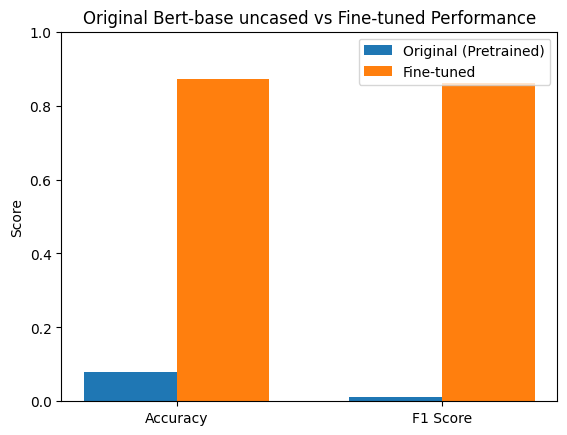

In [51]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "F1 Score"]
orig_values = [orig_acc, orig_f1]
finetuned_values = [acc, f1]

x = range(len(metrics))
width = 0.35

plt.bar([i - width/2 for i in x], orig_values, width=width, label="Original (Pretrained)")
plt.bar([i + width/2 for i in x], finetuned_values, width=width, label="Fine-tuned")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.title("Original Bert-base uncased vs Fine-tuned Performance")
plt.show()